<h1 style="text-align: center; vertical-align: middle;">Numerical Methods of Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture by Dr. Adrian Oeftiger</h2>

<img src="./img/etit.png" style="width: 20%; margin: auto;" />

<h3 style="text-align: center; vertical-align: middle;">Part 10: 13.01.2023</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
1. via the public mybinder.org service: <br />

<p style="text-align: center; margin-left, margin-right: auto; width: 100%;">
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-10/v1.0"><img src="./img/binder_logo.svg" /></a>
</p>
</div>

<div class="alert alert-block alert-success" style="text-align:center;">
2. on the <a href="https://tu-jupyter-i.ca.hrz.tu-darmstadt.de/">local TU Darmstadt jupyterhub $\nearrow$</a> (using your TU ID)

$\implies$ make sure you installed all the required python packages (see the [README](./README.md))!
</div>

Finally, also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-10/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-10).

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config import (np, plt, Madx, interp1d,
                    set_correctors, )
%matplotlib inline

<h2 style="color: #b51f2a">Refresher!</h2>

- Radon transform for line projections, construction of sinogram
- Reconstruction of $n$-dimensional distributions from $(n-1)$-dimensional projections
- Fourier Slice Theorem: Radon + 1D FFT = 2D FFT + slice
- Filtered Back Projection (inverse Radon transform)
- Algebraic Reconstruction Technique, iteratively solve $A\cdot x=b$
- Phase-space Tomography (concept: construction of projection matrix $A$ via non-linear tracking)

<h2 style="color: #b51f2a">In the video for today!</h2>

1. Dipole Errors & Closed Orbit Distortion
2. Local Orbit Correction
3. Global Orbit Correction

<!--<h2 style="color: #b51f2a">Exercises today!</h2>

1. Basics:<br />
    a) compute closed orbit distortion<br />
    b) <br />
    c) determining tune from tracking data vs. phase advance<br />-->

<div style="text-align: center; width:100%;">
    <h2>Part I: Dipole Errors & Closed Orbit Distortion</h2>
</div>

We use the lattice definition of the SIS18 synchrotron (<b>S</b>chwer<b>i</b>onen<b>s</b>ynchrotron) at GSI.

For a sufficient accelerator description we need the following elements <span style="color:#e6541a;">($\implies$ what do they do?)</span>:
- main dipole magnets
- main quadrupole magnets
- dipole corrector magnets
- BPMs (<b>b</b>eam <b>p</b>osition <b>m</b>onitors)

<img src="img/sis18_layout.svg" alt="SIS18 layout" style="float: right; width: 30%; margin-left: 1em; margin-top: 3em;" />

The 216.72m long SIS18 consists of 12 symmetric cells, where each cell basically features:
- two dipole bending magnets
- a quadrupole doublet <br />(one focusing and one defocusing magnet)
- a horizontal corrector <br />(and a separate vertical one)
- a horizontal BPM

<p style="clear: both; font-size: 10pt; text-align: right; float: right;">image by <a href="https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.22.072804">S. Mirza et al.</a></p>

We use once again MAD-X for the calculation of optics:

In [2]:
madx = Madx(stdout=True)
madx.options.echo = False
madx.options.info = False
madx.options.warn = False

madx.set(format_="13.5f") # reduce significant figures

# load the lattice definition (magnet SEQuence)
madx.call('sis18.seq')

# define the beam
madx.beam()
# (normalised multipoles k and optics functions are independent of energy)

# activate lattice
madx.use('sis18ring')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.05.12 16:54:05      +
  ++++++++++++++++++++++++++++++++++++++++++++


Define the quadrupole magnet strengths for the focusing:

In [3]:
madx.input('''
    kqf = 0.387; // focusing k
    kqd = -0.368; // defocusing k
    
    k1nl_GS01QS1F := kqf;
    k1nl_GS01QS2D := kqd;
    k1nl_GS12QS1F := kqf;
    k1nl_GS12QS2D := kqd;
''')

True

Compute the optics for this SIS18 lattice configuration:

In [4]:
# output the Twiss parameters every 0.1m
madx.command.select(flag="interpolate", sequence="sis18ring", step=0.1)

# compute optics
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

       length        orbit5          alfa       gammatr 
    216.72000      -0.00000       0.03172       5.61519 

           q1           dq1       betxmax         dxmax 
      4.30215      -7.33943      34.29041       3.39951 

        dxrms        xcomax        xcorms            q2 
      1.99458       0.00000       0.00000       4.19932 

          dq2       betymax         dymax         dyrms 
     -6.84397      28.30370       0.00000       0.00000 

       ycomax        ycorms        deltap       synch_1 
      0.00000       0.00000       0.00000       0.00000 

      synch_2       synch_3       synch_4       synch_5 
      0.00000       0.00000       0.00000       0.00000 

      synch_6       synch_8        nflips         dqmin 
      0.00000       0.00000       0.00000       0.00000 



How do the beta functions look like around the ring? <span style="color:#e6541a;">($\implies$ what do they represent?)</span>

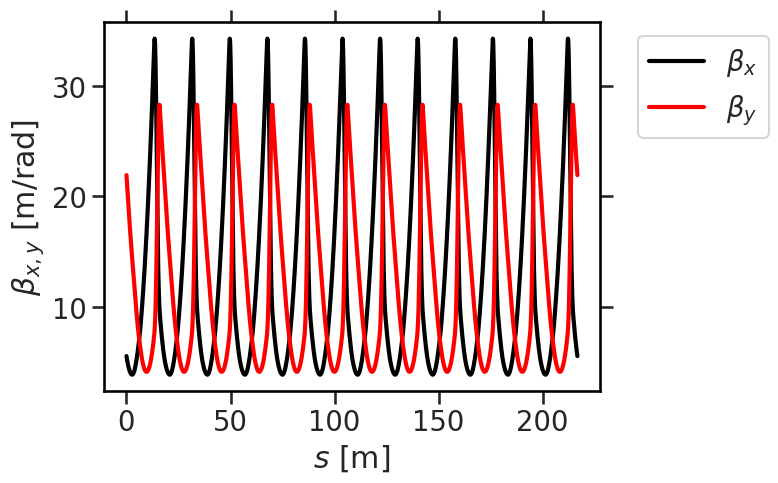

In [5]:
plt.plot(twiss['s'], twiss['betx'], c='k', label=r'$\beta_x$')
plt.plot(twiss['s'], twiss['bety'], c='r', label=r'$\beta_y$')

plt.xlabel('$s$ [m]')
plt.ylabel(r'$\beta_{x,y}$ [m/rad]')
plt.legend(bbox_to_anchor=(1.05, 1));

How does the closed orbit look like with respect to the reference orbit?

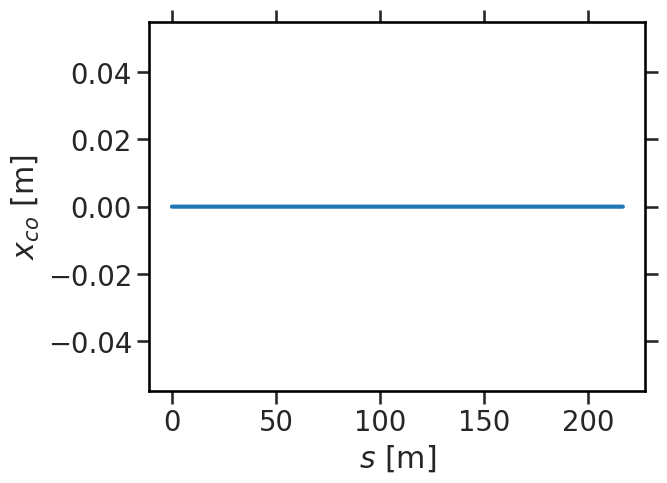

In [6]:
plt.plot(twiss['s'], twiss['x'])

plt.xlabel('$s$ [m]')
plt.ylabel(r'$x_{co}$ [m]');

Collect the locations around the ring where BPMs and corrector magnets are located:

In [7]:
s_bpm = 17.813 + np.linspace(0, twiss.summary.length, 12, endpoint=False)

In [8]:
corrector_names = ['GS01MU1A', 'GS02MU1A', 'GS03MU1A', 'GS04MU2A', 
                   'GS05MU1A', 'GS06MU2A', 'GS07MU1A', 'GS08MU1A', 
                   'GS09MU1A', 'GS10MU1A', 'GS11MU1A', 'GS12MU1A']
s_corr = np.array(
    [twiss['s'][list(twiss['name']).index((cn + ':1').lower())]
     for cn in corrector_names]
)

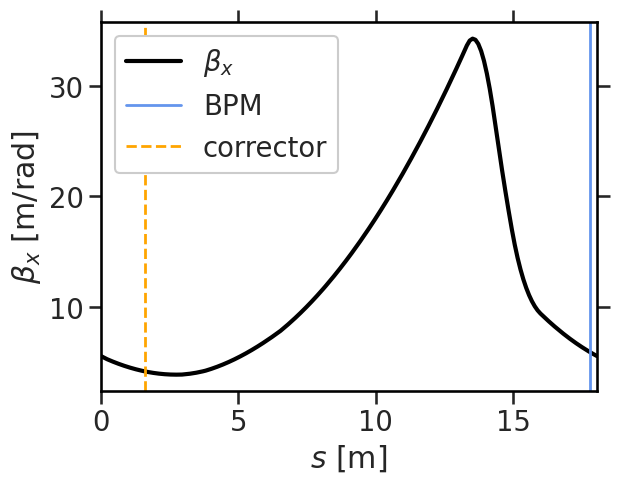

In [9]:
l1, = plt.plot(twiss['s'], twiss['betx'], c='black')

for s in s_bpm:
    l2 = plt.axvline(s, c='cornflowerblue', lw=2)

for s in s_corr:
    l3 = plt.axvline(s, c='orange', ls='--', lw=2)

plt.xlabel('$s$ [m]')
plt.ylabel(r'$\beta_x$ [m/rad]')
plt.legend([l1, l2, l3], [r'$\beta_x$', 'BPM', 'corrector'], loc=0, framealpha=1)

# comment this line to see the whole ring:
plt.xlim(0, twiss.summary.length / 12);

Extract the Twiss $\beta_x(s)$ and phase advance $\psi_x(s)$ functions from the MAD-X TWISS table:

In [10]:
beta_x = interp1d(twiss['s'], twiss['betx'], kind='linear')
psi_x = interp1d(twiss['s'], 2 * np.pi * twiss['mux'], kind='linear')

And the horizontal tune $Q_x$:

In [11]:
Qx = twiss.summary.q1

<h2>Closed Orbit Deviation due to a Dipole Error</h2>

The distortion of the equilibrium orbit at $s$ due to a kick $\theta$ at location $s_0$ is given by

$$x_\mathrm{COD}(s) = \theta \cdot \sqrt{\beta_x(s_0) \cdot \beta_x(s)} \cdot \cfrac{\cos(|\Delta \psi_x| - \pi Q_x)}{2\sin(\pi Q_x)}$$

In [12]:
def x_cod(theta, s_source, s_target):
    sq_betxs = np.sqrt(beta_x(s_source) * beta_x(s_target))
    delta_psi = psi_x(s_target) - psi_x(s_source)
    return theta * sq_betxs / (2 * np.sin(np.pi * Qx)) * np.cos(np.abs(delta_psi) - np.pi * Qx)

Let us consider a dipole "error" of $\theta=0.01\,$rad induced at the location of the first corrector magnet:

Text(0, 0.5, '$x_{co}$ [m]')

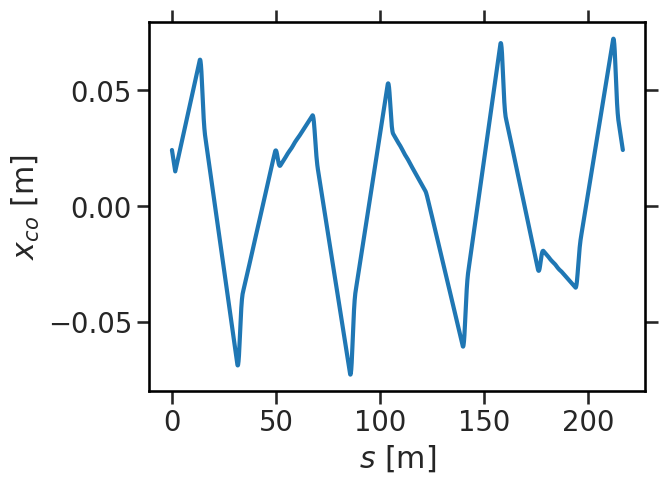

In [13]:
plt.plot(twiss['s'], x_cod(0.01, s_corr[0], twiss['s']))

plt.xlabel('$s$ [m]')
plt.ylabel(r'$x_{co}$ [m]')

Let us see what MAD-X computes for the closed orbit distortion:

In [14]:
set_correctors([0.01] + [0] * 11, madx)

In [15]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   4.815962E-02 deltap:   0.000000E+00
orbit:   2.415323E-02 -5.963771E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   1.926643E-05 deltap:   0.000000E+00
orbit:   2.415184E-02 -5.967624E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.842674E-10 deltap:   0.000000E+00
orbit:   2.415184E-02 -5.967624E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

       length        orbit5          alfa       gammatr 
    216.72000      -0.00000       0.03266       5.53319 

           q1           dq1       betxmax         dxmax 
      4.30249      -7.34282      35.03731       4.84185 

        dxrms        xcomax        xcorms            q2 
      2.11433       0.07333       0.03275       4.19952 

          dq2       betymax         dymax         dyrms 
     -6.84785      28.99330       0.00000       0.00000 

       ycomax        ycorms        

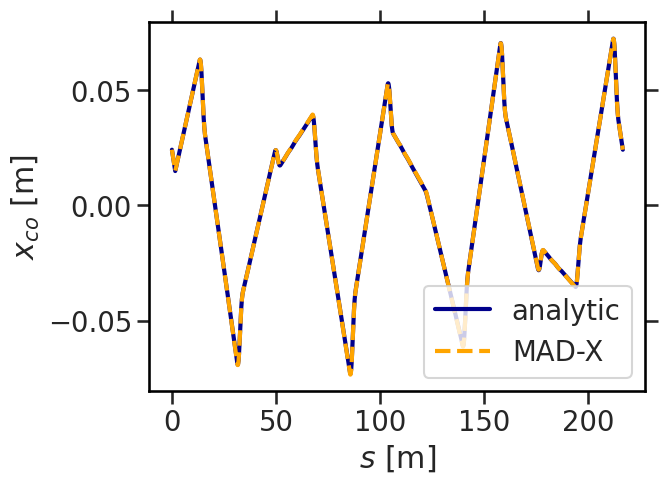

In [16]:
plt.plot(twiss['s'], x_cod(0.01, s_corr[0], twiss['s']), c='darkblue', label='analytic')
plt.plot(twiss['s'], twiss['x'], c='orange', ls='--', label='MAD-X')

plt.xlabel('$s$ [m]')
plt.ylabel(r'$x_{co}$ [m]')
plt.legend();

In [17]:
def reset_correctors():
    set_correctors([0] * 12, madx)

In [18]:
reset_correctors()

### Local 3-Corrector Bump Correction

A dipole error $\Delta x' = \theta$ at $s_0$ is propagated to $s_1$ using the top right entry of the Twiss transfer matrix, $(\mathcal{M}_\mathrm{tw,x}|_{s_1\leftarrow s_0})_{12}$:

$$x_\mathrm{prop}|_{s_1\leftarrow s_0} = \theta \cdot \sqrt{\beta_x(s_0)\cdot \beta_x(s_1)}\cdot \sin(\Delta \psi_x)$$

<!--def x_prop(theta, s_source, s_target):
    sq_betxs = np.sqrt(beta_x(s_source) * beta_x(s_target))
    delta_psi = psi_x(s_target) - psi_x(s_source)
    return theta * sq_betxs * np.sin(delta_psi)-->

Let us shift the closed orbit at $s=10\,$m by $\Delta x=-0.01\,$m:
- we start from the first corrector in the ring at $s_1=1.584\,$m, find the angle $\theta_1$,
- and use the subsequent 2 correctors to close the bump.

In [19]:
dx_target = -0.01

In [20]:
# phase advances:
psi1s = psi_x(10) - psi_x(s_corr[0])
psi12 = psi_x(s_corr[1]) - psi_x(s_corr[0])
psi23 = psi_x(s_corr[2]) - psi_x(s_corr[1])

# beta functions:
betas = beta_x(10)
beta1 = beta_x(s_corr[0])
beta2 = beta_x(s_corr[1])
beta3 = beta_x(s_corr[2])

The first corrector strength is simply $$\theta_1=\cfrac{\Delta x_\mathrm{target}}{\sqrt{\beta_1 \cdot \beta_x(10\,\mathrm{m})} \cdot \sin(\psi_x(s_1)-\psi_x(10\,\mathrm{m}))}$$

In [21]:
theta1 = dx_target / (np.sqrt(beta1 * betas) * np.sin(psi1s))
theta1

-0.0011845798797791632

The second corrector strength was calculated to be $$\theta_2 = -\theta_1\cdot \sqrt{\cfrac{\beta_1}{\beta_2}}\cdot \cfrac{\sin(\psi_{12}+\psi_{23})}{\sin(\psi_{23})}$$

In [22]:
theta2 = -theta1 * np.sqrt(beta1 / beta2) * np.sin(psi12 + psi23) / np.sin(psi23)
theta2

-0.0014930330679946973

And the third corrector closes the bump with
$$\theta_3 = \theta_1 \cdot \sqrt{\cfrac{\beta_1}{\beta_3}}\cdot \cfrac{\sin(\psi_{12})}{\sin(\psi_{23})}$$

In [23]:
theta3 = theta1 * np.sqrt(beta1 / beta3) * np.sin(psi12) / np.sin(psi23)
theta3

-0.0011845798797791636

We apply these computed angles to the 3 first correctors:

In [24]:
set_correctors([theta1, theta2, theta3] + [0] * 9, madx)

Recompute the optics (mainly for the closed orbit):

In [25]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   4.096098E-07 deltap:   0.000000E+00
orbit:  -5.207033E-07 -1.440725E-07  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

       length        orbit5          alfa       gammatr 
    216.72000      -0.00000       0.03158       5.62735 

           q1           dq1       betxmax         dxmax 
      4.30200      -7.33916      34.32811       3.45112 

        dxrms        xcomax        xcorms            q2 
      1.99307       0.01411       0.00296       4.19923 

          dq2       betymax         dymax         dyrms 
     -6.84393      28.33192       0.00000       0.00000 

       ycomax        ycorms        deltap       synch_1 
      0.00000       0.00000       0.00000       0.00000 

      synch_2       synch_3       synch_4       synch_5 
      0.00000       0.00000       0.00000       0.00000 

      synch_6       synch_8        nflips         dqmin 
      0.00000       0.00000       0.00000       0.00000 



Let's plot the 3-corrector bump:

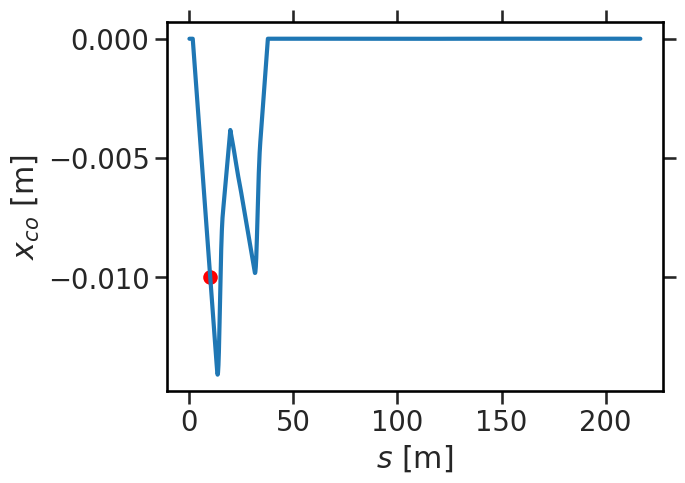

In [26]:
plt.plot(twiss['s'], twiss['x'])
plt.scatter([10], [dx_target], marker='o', c='red')

plt.xlabel('$s$ [m]')
plt.ylabel(r'$x_{co}$ [m]');

In [27]:
reset_correctors()

<div style="text-align: center; width:100%;">
    <h2>Part III: Global Orbit Correction</h2>
</div>

<h2>Construction of Orbit Response Matrix</h2>

The <b>o</b>rbit <b>r</b>esponse <b>m</b>atrix (ORM) $\Omega_{ij}$ is a discrete table describing the linear orbit offset at the $i$th BPM induced by the $j$th dipole corrector magnet, i.e. its angle $\Theta_j$. 

$\Omega$ is, therefore, defined by the relation

$$(\Delta x)_i = \Omega_{ij}\Theta_j$$

- For a <b>one-pass transfer line</b>, $\Omega_{ij}$ is built from the $(\mathcal{M}_\mathrm{tw,x}|_{s_1\leftarrow s_0})_{12}$ values for all $i$ correctors and $j$ BPMs, which is <b>not necessarily periodic</b>.

- For an <b>accelerator ring</b>, on the other hand, the closed orbit is a <b>periodic</b> equilibrium solution and the ORM is built from the $x_{COD}\propto \cfrac{\cos(\Delta\psi_x-\pi Q_x)}{\sin(\pi Q_x)}$ values.

In [28]:
s_mat_corr = np.meshgrid(s_corr, np.ones_like(s_bpm))[0]
s_mat_bpm = np.meshgrid(np.ones_like(s_corr), s_bpm)[1]

Define the ORM:

In [29]:
omega = x_cod(1, s_mat_corr, s_mat_bpm)

<h2>Global Orbit Correction with SVD</h2>

<b>S</b>ingular <b>V</b>alue <b>D</b>ecomposition: factorise $\Omega$ into 
    
$$\Omega=U\cdot S\cdot V^T$$

with the (non-uniquely defined) rectangular orthogonal matrices $U$ and $V$ and the diagonal matrix $S$ listing the (unique, non-negative) singular values.

$U$ and $V$ contain orthonormal vectors along the rows/columns.

$\implies$ SVD constructs the (approximate) null space and provides orthogonal modes in the orbit response matrix to move the orbit!

In [30]:
U, S, Vt = np.linalg.svd(omega)

$U$ and $V$ are orthogonal, i.e. $U\cdot U^T = \mathbb{1} = V \cdot V^T$:

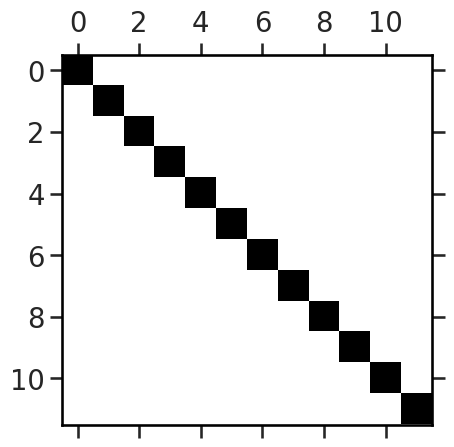

In [31]:
matrix = U

plt.spy(matrix.dot(matrix.T), precision=1e-10)

$S$ contains finite singular values and the (approximately vanishing) null space entries if the system is under-/overdetermined:

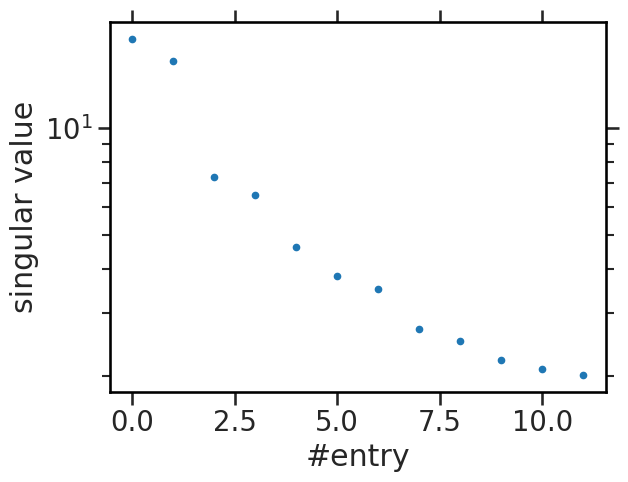

In [32]:
plt.plot(S, ls='none', marker='.')
plt.yscale('log')
plt.xlabel('#entry')
plt.ylabel('singular value');

<h2>Adding random misalignment errors to all quadrupoles</h2>

Consider a horizontal shift $\Delta x_q$ of the magnetic centre of the quadrupole magnets.

<p style="color:#e6541a;">$\implies$ What happens to a beam centroid entering a quadrupole field off-centre?</p>

In [33]:
reset_correctors()

Random Gaussian normal distribution of the misalignments with a standard deviation of $\sigma_{\Delta x_q} = 1\,$mm:

In [34]:
madx.input('''
    sigmadx = 0.001; // 1mm
    
    select, flag=error, clear;
    select, flag=error, class=quadrupole;
    
    eoption, add=false, seed=12345;
    
    ealign, dx := sigmadx * tgauss(2);
''')

True

Let us plot the distribution of horizontal misalignments for the quadrupoles around the ring:

In [35]:
quads = [el for el in madx.sequence.sis18ring.expanded_elements if 'quad_long' in str(el)]

quad_s = np.array([twiss['s'][list(twiss['name']).index(q.name.lower() + ':1')] for q in quads])
quad_dx = np.array([q.align_errors.dx for q in quads])

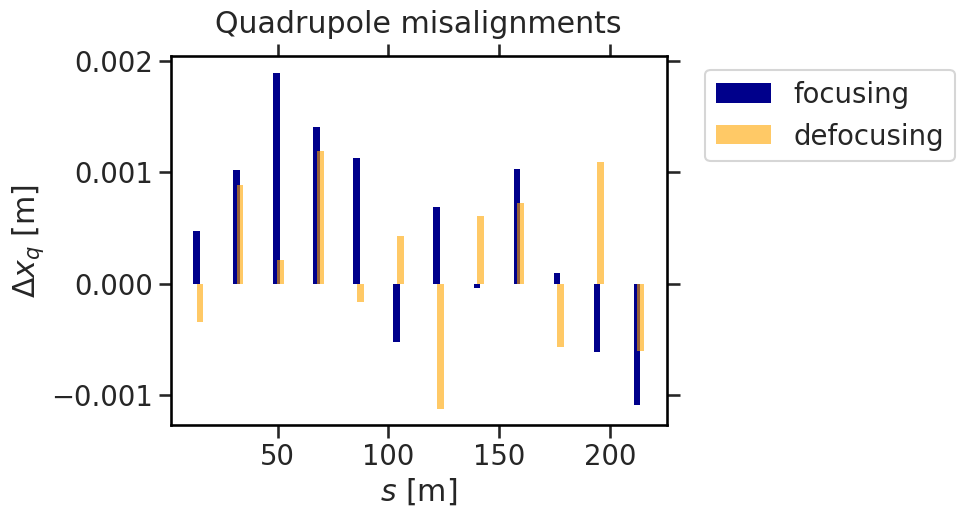

In [36]:
plt.bar(quad_s[::2], quad_dx[::2], width=3, 
        facecolor='darkblue', edgecolor='none', label='focusing')
plt.bar(quad_s[1::2], quad_dx[1::2], width=3, 
        facecolor='orange', edgecolor='none', alpha=0.6, label='defocusing')
plt.xlabel('$s$ [m]')
plt.ylabel('$\Delta x_{q}$ [m]')
plt.title('Quadrupole misalignments', y=1.04)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

In [37]:
# recompute optics
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   1.142975E-02 deltap:   0.000000E+00
orbit:  -3.120383E-03  1.762989E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   2.679426E-06 deltap:   0.000000E+00
orbit:  -3.119209E-03  1.762633E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.317965E-12 deltap:   0.000000E+00
orbit:  -3.119209E-03  1.762633E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

       length        orbit5          alfa       gammatr 
    216.72000      -0.00000       0.03177       5.61014 

           q1           dq1       betxmax         dxmax 
      4.30226      -7.33998      34.43140       3.92505 

        dxrms        xcomax        xcorms            q2 
      2.00303       0.03432       0.00981       4.19942 

          dq2       betymax         dymax         dyrms 
     -6.84447      28.47205       0.00000       0.00000 

       ycomax        ycorms        

In [38]:
beta_x = interp1d(twiss['s'], twiss['betx'], kind='linear')
psi_x = interp1d(twiss['s'], 2 * np.pi * twiss['mux'], kind='linear')

x_co = interp1d(twiss['s'], twiss['x'], kind='linear')

In [39]:
x_co_bpm = x_co(s_bpm)

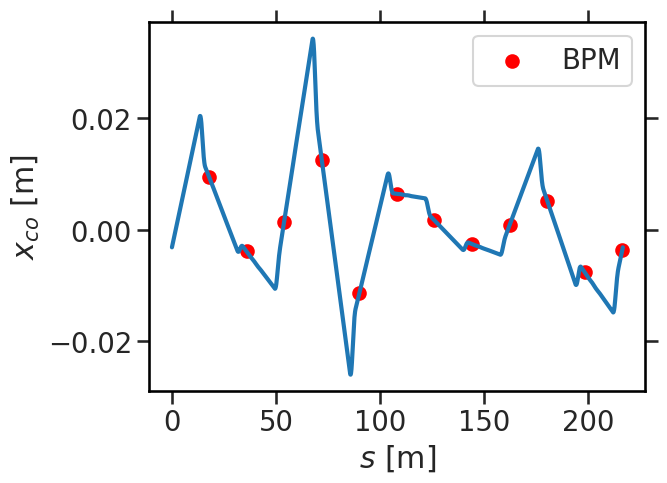

In [40]:
plt.plot(twiss['s'], twiss['x'])

plt.scatter(s_bpm, x_co_bpm, marker='o', c='r', label='BPM')

plt.xlabel('$s$ [m]')
plt.ylabel(r'$x_{co}$ [m]')
plt.legend();

<h2>Let's Correct!</h2>

Construct pseudo-inverse of ORM:

$$\Omega^{-1} = (U\cdot \mathrm{diag}(S_{ii}) \cdot V^T)^{-1} = (V^T)^{-1} \cdot S^{-1} \cdot U^{-1} = V \cdot \mathrm{diag}\left(\frac{1}{S_{ii}}\right) \cdot U^T$$

where $S_{ii}$ refers to the finite singular values (i.e. excluding the null space).

In [41]:
S_mat = np.diag(S)

S_inv_mat = np.diag(1/S)

The goal is to induce a shift $(\Delta x_\mathrm{target})_i$ at each $i$th BPM: this can be 
- to remove the measured closed orbit deviation, $(\Delta x_\mathrm{target})_i = -\Delta x_{i}$, or/and
- to deliberately introduce local orbit offsets (using all correctors around the ring unlike in the case of the local orbit correction).

The corrector angles are then given by $\Omega^{-1} \Delta x_\mathrm{target}$,

In [42]:
omega_inv = Vt.T.dot(
              (S_inv_mat).dot(U.T))

We set $\Delta x_\mathrm{target}$ to the negative values of the observed horizontal positions at the BPMs, this will move the closed orbit (in the BPMs) back towards the reference orbit (zero):

In [43]:
theta_vec = omega_inv.dot(-x_co_bpm)

Set the corrector strengths $\Theta_j$:

In [44]:
set_correctors(theta_vec, madx)

And recompute the optics (mainly the closed orbit):

In [45]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   1.175661E-03 deltap:   0.000000E+00
orbit:  -5.930454E-05 -2.317281E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   5.877478E-09 deltap:   0.000000E+00
orbit:  -5.929467E-05 -2.317264E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

       length        orbit5          alfa       gammatr 
    216.72000      -0.00000       0.03163       5.62258 

           q1           dq1       betxmax         dxmax 
      4.30217      -7.33961      34.33156       3.54981 

        dxrms        xcomax        xcorms            q2 
      1.99376       0.01224       0.00464       4.19944 

          dq2       betymax         dymax         dyrms 
     -6.84455      28.35124       0.00000       0.00000 

       ycomax        ycorms        deltap       synch_1 
      0.00000       0.00000       0.00000       0.00000 

      synch_2       synch_3       synch_4       synch_5 
      0.00000     

Let us plot the closed orbit after correction now!

In [46]:
x_co = interp1d(twiss['s'], twiss['x'], kind='linear')

x_co_bpm = x_co(s_bpm)

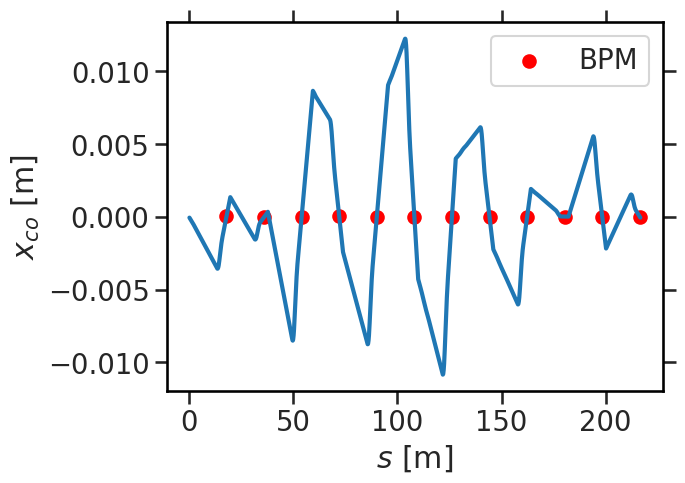

In [47]:
plt.plot(twiss['s'], twiss['x'])

plt.scatter(s_bpm, x_co_bpm, marker='o', c='r', label='BPM')

plt.xlabel('$s$ [m]')
plt.ylabel(r'$x_{co}$ [m]')
plt.legend();


<p style="color:#e6541a;">$\implies$ Can you describe and explain what you observe?</p>

Let us plot the used corrector strengths $\Theta_j$:

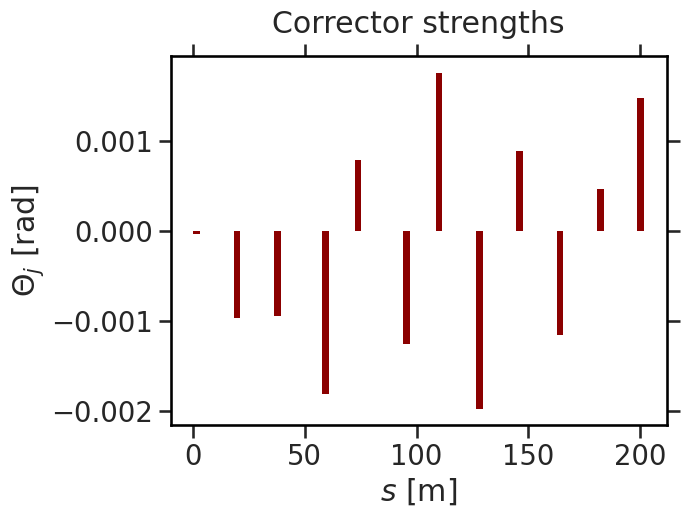

In [48]:
plt.bar(s_corr, theta_vec, width=3, facecolor='darkred', edgecolor='none')
plt.xlabel('$s$ [m]')
plt.ylabel('$\Theta_j$ [rad]')
plt.title('Corrector strengths', y=1.04);

In [49]:
reset_correctors()

In [50]:
s_save = np.array(twiss['s']).copy()
x_save = np.array(twiss['x']).copy()

<h2>Global Orbit Correction with MAD-X</h2>

Let MAD-X do the job for us:

In [51]:
madx.input('''
select, flag=twiss, clear;
select, flag=twiss, class=GS00DX5H;
twiss, file="bpm.tsv";
''')

enter Twiss module
  
iteration:   1 error:   1.142975E-02 deltap:   0.000000E+00
orbit:  -3.120383E-03  1.762989E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   2.679426E-06 deltap:   0.000000E+00
orbit:  -3.119209E-03  1.762633E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.317965E-12 deltap:   0.000000E+00
orbit:  -3.119209E-03  1.762633E-03  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

       length        orbit5          alfa       gammatr 
    216.72000      -0.00000       0.03177       5.61014 

           q1           dq1       betxmax         dxmax 
      4.30226      -7.33998      34.43140       3.92505 

        dxrms        xcomax        xcorms            q2 
      2.00303       0.03432       0.00981       4.19942 

          dq2       betymax         dymax         dyrms 
     -6.84447      28.47205       0.00000       0.00000 

       ycomax        ycorms        

True

In [52]:
madx.input('''
    readmytable, file="bpm.tsv", table="twiss_bpm";
''')

Want to make named table: twiss_bpm


True

Here comes the correction command, using also the SVD algorithm:

In [53]:
madx.input('''
    correct, flag=ring, mode=svd, plane=x, error=1.0e-10, extern, orbit=twiss_bpm, clist="corr.tab";
''')

Want to correct orbit of a single ring
Want to use orbit from: twiss_bpm
20 monitors and 12 correctors found in input
12 monitors and 12 correctors enabled

start SVD correction using    12 correctors

CORRECTION SUMMARY:   

                   average [mm]   std.dev. [mm]      RMS [mm]        peak-to-peak [mm]

before correction: 0.760000        6.654684          6.697941        23.720000 
after correction:  0.000000        0.000000          0.000000        0.000000 


Max strength: 1.948182e+00 should be less than corrector strength limit: 1.000000e+00


True

<!--These are the corrector angles (`PX.CORRECTION` $=\Theta_j$) found by MAD-X:

!cat corr.tab
-->

In [54]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   1.265436E-03 deltap:   0.000000E+00
orbit:  -4.551246E-05 -2.470152E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   6.045699E-09 deltap:   0.000000E+00
orbit:  -4.550017E-05 -2.470137E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

       length        orbit5          alfa       gammatr 
    216.72000      -0.00000       0.03163       5.62277 

           q1           dq1       betxmax         dxmax 
      4.30217      -7.33960      34.33280       3.55307 

        dxrms        xcomax        xcorms            q2 
      1.99375       0.01242       0.00467       4.19944 

          dq2       betymax         dymax         dyrms 
     -6.84454      28.35251       0.00000       0.00000 

       ycomax        ycorms        deltap       synch_1 
      0.00000       0.00000       0.00000       0.00000 

      synch_2       synch_3       synch_4       synch_5 
      0.00000     

Plot the MAD-X result for the corrected closed orbit. Compare to our self-implemented SVD algorithm with the orbit response matrix defined by the $x_\mathrm{COD}(s)$ expression:

In [55]:
x_co = interp1d(twiss['s'], twiss['x'], kind='linear')

x_co_bpm = x_co(s_bpm)

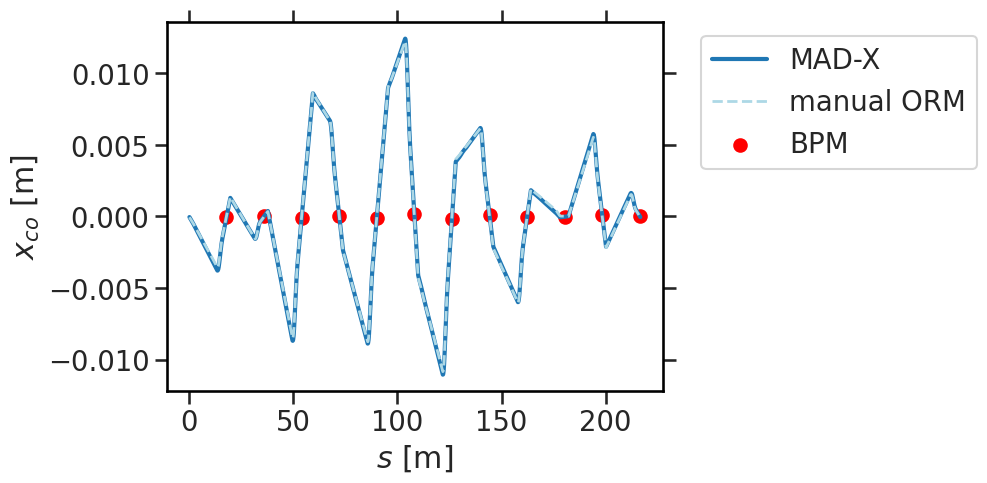

In [56]:
plt.plot(twiss['s'], twiss['x'], label='MAD-X')
plt.plot(s_save, x_save, c='lightblue', ls='--', lw=2, label='manual ORM')

plt.scatter(s_bpm, x_co_bpm, marker='o', c='r', label='BPM')

plt.xlabel('$s$ [m]')
plt.ylabel(r'$x_{co}$ [m]')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

Let us compare the obtained kick strengths from MAD-X to our SVD implementation:

In [57]:
theta_vec_madx = [el.chkick for el in madx.sequence.sis18ring.expanded_elements if 'gs00mu1a' in str(el)]

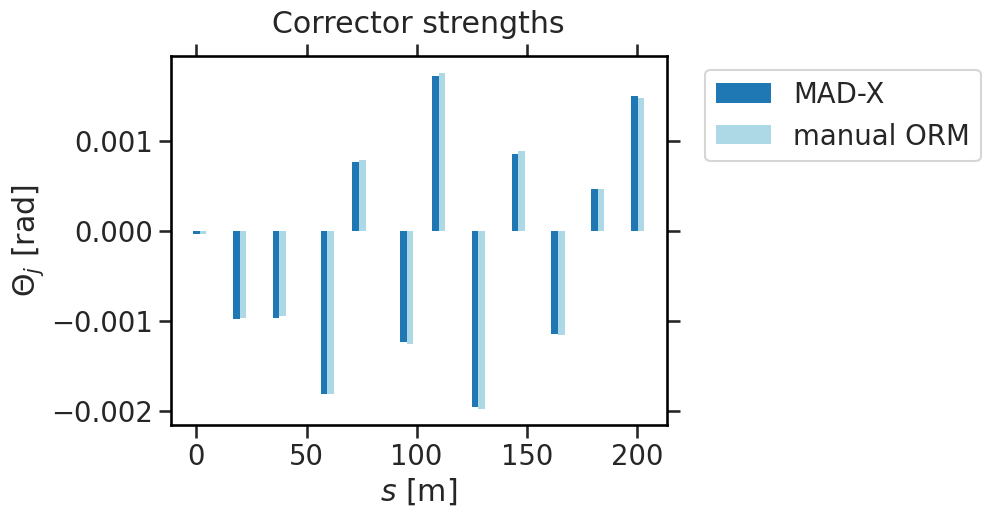

In [58]:
plt.bar(s_corr - 1.5, theta_vec_madx, width=3, facecolor='C0', edgecolor='none', label='MAD-X')
plt.bar(s_corr + 1.5, theta_vec, width=3, facecolor='lightblue', edgecolor='none', label='manual ORM')

plt.xlabel('$s$ [m]')
plt.ylabel('$\Theta_j$ [rad]')
plt.title('Corrector strengths', y=1.04)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

$\implies$ <b>global orbit correction</b> will correct the orbit at the BPMs to zero and usually reduce the overall rms closed orbit distortion! <b>Local orbit correction</b> can help on top to bring down excessive peaks in between BPMs (e.g. when the aperture (vacuum tube around the beam) is hit and beam loss monitors indicate the location in the ring).

<h2>Summary</h2>

- closed orbit distortion due to dipole error
- periodic and non-periodic (propagated) solutions, $x_\mathrm{COD}(s)$ and $x_\mathrm{prop}(s)$
- local orbit correction: 3-corrector bump
- orbit response matrix $\Omega$
- global orbit correction: SVD algorithm

<h2>Literature</h2>

- an old but comprehensive overview of trajectory and orbit correction: <a href="http://cds.cern.ch/record/195334/files/cer-000106955.pdf">J.P. Koutchouk, CERN 1989</a>